Reference: https://github.com/Eligijus112/Vilnius-weather-LSTM

### Get Data

In [1]:
%%bash
if [ ! -d '/content/data' ]; then
  git clone https://gitlab.com/Dimu_1020/big_data_final '/content/data'
  cd '/content/data'
else
  echo "Dataset already downloaded in '/content/data'"
fi

Cloning into '/content/data'...


### Import dependencies

In [2]:
pip install pyspark

     |████████████████████████████████| 281.3 MB 45 kB/s 
     |████████████████████████████████| 198 kB 37.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=1cc1e555ba755771ca3c0873d12f7a8aa5a1af495969f3ff03c1b2d20299232e
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [3]:
# Data wrangling
import pandas as pd 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

# Date wrangling
import datetime

# Math operations
import numpy as np

# Random sampling
import random

# sklearn
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

# Keras API 
from tensorflow import keras

# Deep learning 
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Concatenate, SimpleRNN, Masking, Flatten
from keras import losses
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal

# pyspark related
# pip install pyspark
import pyspark
from pyspark.sql.functions import split, explode, to_timestamp, from_unixtime, from_utc_timestamp
from pyspark import SparkConf, SparkContext,SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType,ArrayType,StringType,DoubleType
from pyspark.sql.functions import *
from pyspark.sql import Window
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
#from ts.flint import FlintContext
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


## Data Cleaning

### Convert into rdd

In [4]:
spark = SparkSession.builder.appName("DataFrame").getOrCreate()
path_to_file = 'data/weather.csv'
df = spark.read.csv(path_to_file, header=True)
df.show()

+---------+--------------------+--------+----------------+---------+---------+-----+----------+--------+--------+--------+---------+----------+--------+----------+--------+-------+-------+-------+-------+----------+----------+------------+-------------------+------------+
|       dt|              dt_iso|timezone|       city_name|      lat|      lon| temp|feels_like|temp_min|temp_max|pressure|sea_level|grnd_level|humidity|wind_speed|wind_deg|rain_1h|rain_3h|snow_1h|snow_3h|clouds_all|weather_id|weather_main|weather_description|weather_icon|
+---------+--------------------+--------+----------------+---------+---------+-----+----------+--------+--------+--------+---------+----------+--------+----------+--------+-------+-------+-------+-------+----------+----------+------------+-------------------+------------+
|631152000|1990-01-01 00:00:...|    7200|Vilnius TV Tower|54.687137|25.214648|-7.52|    -11.92|   -7.74|    -7.4|    1032|     null|      null|      87|         2|     180|   null| 

### Get datetime

In [5]:
# convert to datestamp
spark.conf.set('spark.sql.session.timeZone', 'UTC')
df = df.withColumn("dt",from_unixtime(unix_timestamp(col("dt_iso"),"yyyy-MM-dd HH:mm:ss '+0000 UTC'"),'yyyy-MM-dd HH:mm:ss').cast("timestamp"))
# Sorting by the date 
df = df.sort(asc("dt"))
df.show()

+-------------------+--------------------+--------+----------------+---------+---------+-----+----------+--------+--------+--------+---------+----------+--------+----------+--------+-------+-------+-------+-------+----------+----------+------------+-------------------+------------+
|                 dt|              dt_iso|timezone|       city_name|      lat|      lon| temp|feels_like|temp_min|temp_max|pressure|sea_level|grnd_level|humidity|wind_speed|wind_deg|rain_1h|rain_3h|snow_1h|snow_3h|clouds_all|weather_id|weather_main|weather_description|weather_icon|
+-------------------+--------------------+--------+----------------+---------+---------+-----+----------+--------+--------+--------+---------+----------+--------+----------+--------+-------+-------+-------+-------+----------+----------+------------+-------------------+------------+
|1990-01-01 00:00:00|1990-01-01 00:00:...|    7200|Vilnius TV Tower|54.687137|25.214648|-7.52|    -11.92|   -7.74|    -7.4|    1032|     null|      nul

In [6]:
# Listing the min and the max dates
first = df.agg({'dt': "min"}).collect()[0][0] 
last = df.agg({'dt': "max"}).collect()[0][0]
print(f"First date {first}")
print(f"Most recent date {last}")

First date 1990-01-01 00:00:00
Most recent date 2020-11-30 23:00:00


### Get date

In [7]:
df = df.withColumn("date",to_date("dt_iso"))
df.show()

+-------------------+--------------------+--------+----------------+---------+---------+-----+----------+--------+--------+--------+---------+----------+--------+----------+--------+-------+-------+-------+-------+----------+----------+------------+-------------------+------------+----------+
|                 dt|              dt_iso|timezone|       city_name|      lat|      lon| temp|feels_like|temp_min|temp_max|pressure|sea_level|grnd_level|humidity|wind_speed|wind_deg|rain_1h|rain_3h|snow_1h|snow_3h|clouds_all|weather_id|weather_main|weather_description|weather_icon|      date|
+-------------------+--------------------+--------+----------------+---------+---------+-----+----------+--------+--------+--------+---------+----------+--------+----------+--------+-------+-------+-------+-------+----------+----------+------------+-------------------+------------+----------+
|1990-01-01 00:00:00|1990-01-01 00:00:...|    7200|Vilnius TV Tower|54.687137|25.214648|-7.52|    -11.92|   -7.74|    

### Select Features

In [8]:
features = ['temp', 'pressure', 'wind_speed']
data_col = ['dt', 'date'] + features

### Get Hourly Data

In [9]:
# Aggregating to hourly level
df_data = df.select(data_col).withColumn("temp", avg("temp").over(Window.partitionBy("dt"))) \
                   .withColumn("pressure", avg("pressure").over(Window.partitionBy("dt"))) \
                   .withColumn("wind_speed", avg("wind_speed").over(Window.partitionBy("dt")))
df_data.show()
# df.select(['dt']+features).groupBy(df.dt).avg().collect()

+-------------------+----------+-----+--------+----------+
|                 dt|      date| temp|pressure|wind_speed|
+-------------------+----------+-----+--------+----------+
|1990-01-01 00:00:00|1990-01-01|-7.52|  1032.0|       2.0|
|1990-01-01 01:00:00|1990-01-01|-7.56|  1032.0|       2.0|
|1990-01-01 02:00:00|1990-01-01|-7.67|  1028.0|      2.08|
|1990-01-01 03:00:00|1990-01-01|-7.74|  1028.0|      2.18|
|1990-01-01 04:00:00|1990-01-01|-7.66|  1028.0|      2.12|
|1990-01-01 05:00:00|1990-01-01|-7.08|  1030.0|       2.0|
|1990-01-01 06:00:00|1990-01-01|-7.01|  1030.0|       2.0|
|1990-01-01 07:00:00|1990-01-01|-6.93|  1030.0|       2.0|
|1990-01-01 08:00:00|1990-01-01|-6.32|  1026.0|      2.22|
|1990-01-01 09:00:00|1990-01-01|-6.07|  1026.0|      2.23|
|1990-01-01 10:00:00|1990-01-01|-5.44|  1026.0|      2.27|
|1990-01-01 11:00:00|1990-01-01|-5.31|  1027.0|       2.0|
|1990-01-01 12:00:00|1990-01-01|-5.27|  1027.0|       2.0|
|1990-01-01 13:00:00|1990-01-01|-5.23|  1027.0|       2.

### Final Dataset

In [10]:
# get integer timestamp
df_data = df_data.withColumn('timestamp',unix_timestamp(col('dt'), format='yyyy-MM-dd HH:mm:ss').alias('unix_timestamp'))

# Seconds in day 
SECOND = 24 * 60 * 60 

# Seconds in year 
YEAR = (365.25) * SECOND

features_final = ['temp', 'day_cos', 'day_sin', 'month_sin', 'month_cos', 'pressure', 'wind_speed']
df_final = df_data.withColumn('hour', hour(df_data.dt)) \
       .withColumn('month', month(df_data.dt)) \
       .withColumn('day_cos', cos(col('hour') * (2 * np.pi / 24))) \
       .withColumn('day_sin', sin(col('hour') * (2 * np.pi /24))) \
       .withColumn('month_cos', cos(col('timestamp') * (2 * np.pi /YEAR))) \
       .withColumn('month_sin', sin(col('timestamp') * (2 * np.pi /YEAR))) \
       .select(features_final)
df_final.show()

+-----+--------------------+--------------------+--------------------+------------------+--------+----------+
| temp|             day_cos|             day_sin|           month_sin|         month_cos|pressure|wind_speed|
+-----+--------------------+--------------------+--------------------+------------------+--------+----------+
|-7.52|                 1.0|                 0.0|-4.89858719658941...|               1.0|  1032.0|       2.0|
|-7.56|  0.9659258262890683| 0.25881904510252074|7.167675985875918E-4|0.9999997431220718|  1032.0|       2.0|
|-7.67|  0.8660254037844387| 0.49999999999999994|0.001433534828922...|0.9999989724884193|  1028.0|      2.08|
|-7.74|  0.7071067811865476|  0.7071067811865475|0.002150301322770...|0.9999976880994382|  1028.0|      2.18|
|-7.66|  0.5000000000000001|  0.8660254037844386|0.002867066711902262|0.9999958899557885|  1028.0|      2.12|
|-7.08| 0.25881904510252096|  0.9659258262890682|0.003583830628047865|0.9999935780583941|  1030.0|       2.0|
|-7.01|6.1

In [11]:
df_final_tmp = df_final
unlist = udf(lambda x: float(x[0]), DoubleType())
for col in features_final:
    assembler = VectorAssembler(inputCols=[col],outputCol=col+"_Vect")
    scaler = StandardScaler(inputCol=col+"_Vect", outputCol=col+"_Scaled")
    pipeline = Pipeline(stages=[assembler, scaler])
    df_final_tmp = pipeline.fit(df_final_tmp).transform(df_final_tmp).withColumn(col+"_Scaled", unlist(col+"_Scaled")).drop(col+"_Vect")
df_final_tmp.dtypes
df_final_scaled = df_final_tmp.select([col + '_scaled' for col in features_final])
df_final_scaled.show()

+-------------------+--------------------+--------------------+--------------------+------------------+------------------+-------------------+
|        temp_scaled|      day_cos_scaled|      day_sin_scaled|    month_sin_scaled|  month_cos_scaled|   pressure_scaled|  wind_speed_scaled|
+-------------------+--------------------+--------------------+--------------------+------------------+------------------+-------------------+
|-0.8055317901963281|  1.4130140068825476|                 0.0|-6.94528479923690...|1.4119562669110173|102.33630315350962| 0.9598559950156853|
|-0.8098165337612022|   1.364866722156052|  0.3663561606964788|0.001016243032383...| 1.411955904210617|102.33630315350962| 0.9598559950156853|
| -0.821599578564606|   1.223706025863526|  0.7077457544736739| 0.00203248554265255|1.4119548161096016|101.93965081570532| 0.9982502348163127|
|-0.8290978798031357|  0.9991517861782244|  1.0009036446886483|0.003048727008720...|1.4119530026085305|101.93965081570532|  1.046243034567097|

### convert to pandas dataframe

In [12]:
pd_final = df_final_scaled.toPandas()
pd_final

,temp_scaled,day_cos_scaled,day_sin_scaled,month_sin_scaled,month_cos_scaled,pressure_scaled,wind_speed_scaled
0,-0.805532,1.413014,0.000000,-6.945285e-15,1.411956,102.336303,0.959856
1,-0.809817,1.364867,0.366356,1.016243e-03,1.411956,102.336303,0.959856
2,-0.821600,1.223706,0.707746,2.032486e-03,1.411955,101.939651,0.998250
3,-0.829098,0.999152,1.000904,3.048727e-03,1.411953,101.939651,1.046243
4,-0.820528,0.706507,1.225852,4.064967e-03,1.411950,101.939651,1.017447
...,...,...,...,...,...,...,...
294222,-0.091051,0.706507,-1.225852,-7.190038e-01,1.216929,101.344672,2.207669
294223,-0.091051,0.999152,-1.000904,-7.181277e-01,1.217442,101.344672,2.735590
294224,-0.091051,1.223706,-0.707746,-7.172513e-01,1.217954,101.344672,2.975554
294225,-0.071769,1.364867,-0.366356,-7.163745e-01,1.218466,101.344672,2.975554


## Data Modeling

## Forecast

In [13]:
# Number of lags (hours back) to use for models
lag = 48

# Steps ahead to forecast 
n_ahead = 1

# Share of obs in testing 
test_share = 0.1

# Epochs for training
epochs = 20

# Batch size 
batch_size = 512

# Learning rate
lr = 0.001

# Number of neurons in LSTM layer
n_layer = 10

# The features used in the modeling 
features_final = ['temp', 'day_cos', 'day_sin', 'month_sin', 'month_cos', 'pressure', 'wind_speed']

In [14]:
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

#### Train Test Split

In [15]:
# Subseting only the needed columns 
ts = pd_final

nrows = ts.shape[0]

# Spliting into train and test sets
train = ts[0:int(nrows * (1 - test_share))]
test = ts[int(nrows * (1 - test_share)):]

# Creating the final scaled frame 
ts_s = pd.concat([train, test])
X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)

n_ft = X.shape[2]

# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]


In [16]:
class NNMultistepModel_tp():
    
    def __init__(
        self, 
        X, 
        Y, 
        n_outputs,
        n_lag,
        n_ft,
        n_layer,
        batch,
        epochs, 
        lr,
        Xval=None,
        Yval=None,
        mask_value=-999.0,
        min_delta=0.001,
        patience=5
    ):
        lstm_input = Input(shape=(n_lag, n_ft))

        # Series signal 
        lstm_layer = LSTM(n_layer, activation='relu')(lstm_input)

        x = Dense(n_outputs)(lstm_layer)
        
        self.model = Model(inputs=lstm_input, outputs=x)
        self.batch = batch 
        self.epochs = epochs
        self.n_layer=n_layer
        self.lr = lr 
        self.Xval = Xval
        self.Yval = Yval
        self.X = X
        self.Y = Y
        self.mask_value = mask_value
        self.min_delta = min_delta
        self.patience = patience

    def trainCallback(self):
        return EarlyStopping(monitor='loss', patience=self.patience, min_delta=self.min_delta)

    def train(self):
        # Getting the untrained model 
        empty_model = self.model
        
        # Initiating the optimizer
        optimizer = keras.optimizers.Adam(learning_rate=self.lr)

        # Compiling the model
        empty_model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)

        if (self.Xval is not None) & (self.Yval is not None):
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch, 
                validation_data=(self.Xval, self.Yval), 
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        else:
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch,
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        
        # Saving to original model attribute in the class
        self.model = empty_model
        
        # Returning the training history
        return history
    
    def predict(self, X):
        return self.model.predict(X)

model = NNMultistepModel_tp(
    X=Xtrain,
    Y=Ytrain,
    n_outputs=n_ahead,
    n_lag=lag,
    n_ft=n_ft,
    n_layer=n_layer,
    batch=batch_size,
    epochs=epochs, 
    lr=lr,
    Xval=Xval,
    Yval=Yval,
)

In [17]:
model.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 7)]           0         
                                                                 
 lstm (LSTM)                 (None, 10)                720       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 731
Trainable params: 731
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.train()

Epoch 1/20
518/518 [==============================] - 76s 142ms/step - loss: 9.7205 - val_loss: 5.4858
Epoch 2/20
518/518 [==============================] - 73s 141ms/step - loss: 4.8371 - val_loss: 3.8933
Epoch 3/20
518/518 [==============================] - 74s 142ms/step - loss: 3.2580 - val_loss: 2.3855
Epoch 4/20
518/518 [==============================] - 73s 142ms/step - loss: 1.8482 - val_loss: 1.1197
Epoch 5/20
518/518 [==============================] - 73s 142ms/step - loss: 1.0466 - val_loss: 0.7016
Epoch 6/20
518/518 [==============================] - 72s 139ms/step - loss: 0.9373 - val_loss: 0.6616
Epoch 7/20
518/518 [==============================] - 73s 141ms/step - loss: 0.9114 - val_loss: 0.6526
Epoch 8/20
518/518 [==============================] - 71s 137ms/step - loss: 0.8969 - val_loss: 0.6499
Epoch 9/20
518/518 [==============================] - 72s 138ms/step - loss: 0.8889 - val_loss: 0.6463
Epoch 10/20
518/518 [==============================] - 73s 141ms/step - l

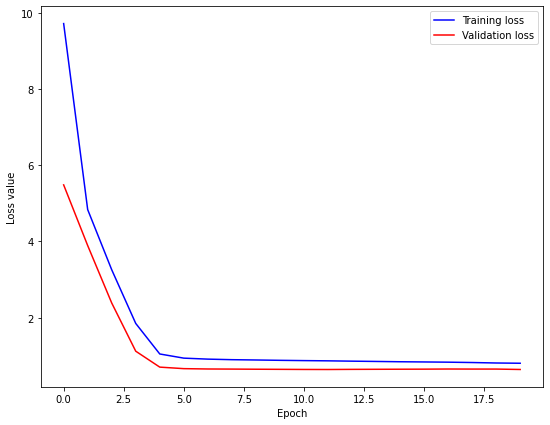

In [19]:
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(loss))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, loss, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [20]:
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model.predict(Xval)]
y = [y[0] for y in Yval]

In [21]:
# import pickle
# filename = 'Temperature_prediction_lstm_model.sav'
# pickle.dump(model, open(filename, 'wb'))

In [23]:
model.model.save('Temperature_prediction_lstm_model.h5')
from google.colab import files
files.download("/content/Temperature_prediction_lstm_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>